Notebook purpose

- Decide how to identify savings transactions

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures as fig
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [19]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 1.59 seconds
Time for read_sample    : 4.56 minutes
(14,839,981, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1859849,2012-11-05,57,-700.0,faster payments receipt ref mdbremoved,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2012-10-23,274000,2020-08-16 07:24:00,santander,current,2014-07-18,2017-08-15,False,14829.769531,NaN,NaN,NaN,current account,u,201211,8504.292969,22136.039062,2.397678
1,1859848,2012-11-08,57,-900.0,faster payments receipt from mdbremoved,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2012-10-23,274000,2020-08-16 07:24:00,santander,current,2014-07-18,2017-08-15,False,14829.769531,NaN,NaN,NaN,current account,u,201211,9404.292969,22136.039062,2.397678


## Tags

The simplest approach to identify savings is to use MDB auto tags. I have grouped all relevant auto tags into a `tag` called *savings*, which is a subgroup of the `tag_group` *transfters*.

In [20]:
tc.transfers_subgroups["savings"]

['general savings',
 'investment - other',
 'investments or shares',
 'isa',
 'pension or investments',
 'saving (general)',
 'savings (general)',
 'savings']

But there are not enough txns and users to work with, so I won't use these.

In [21]:
savings = df[df.tag.eq("savings")]
hd.txns_and_users(savings, df)

df1 has 43,745 txns across 2495 users (0.3% and 42.1% of df2).


## Savings account transfers

An alternative is to look at flows into and out of savings accounts. We could define something like 'monthly net savings' as the the sum of all inflows and outflows into a users savings accounts during a month.

In [22]:
savings = df[df.account_type.eq("savings")]
credits = savings[~savings.debit]
debits = savings[savings.debit]

There are many more transactions across many more users than for tags above.

In [23]:
hd.txns_and_users(savings, df)

df1 has 395,170 txns across 3425 users (2.7% and 57.8% of df2).


Plot distributions of monthly inflows, outflows, and net savings.

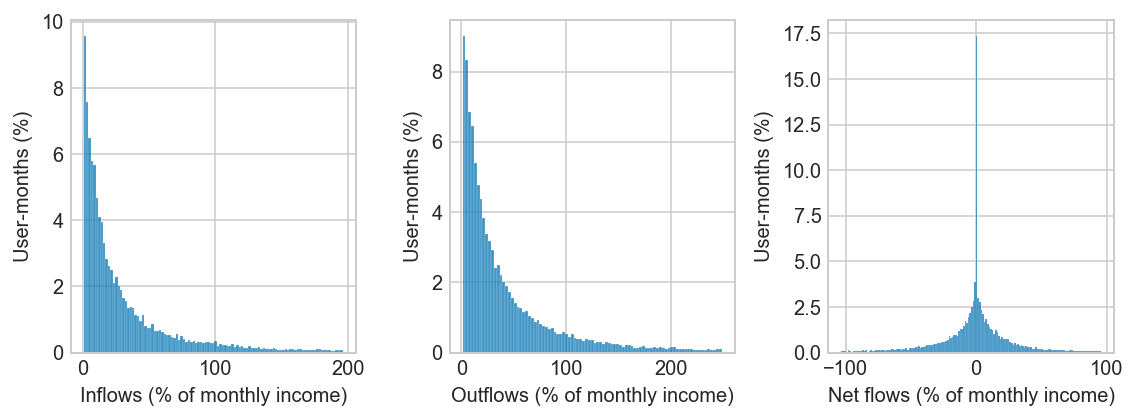

In [25]:
fig.monthly_savings.main(df)

## ISA transactions

## Non-standing-order transactions only

### Question

Should we exclude standing order transactions from savings transactions identified above?

Strategy: check proportion of saving account in and outflows that are standing orders. If the proportion is significant, then we should exclude them and only focus on non-standing orders. If only very few transactions are standing orders, then there is no need to exclude them as they won't affect the results anyways.

Tactic: focus on a single large back for which we can identify standing orders. I need to use raw data because as part of data cleaning process I clean up transaction description and, among other things, remove suffixes like 'so', which indicates standing orders.

In [147]:
fs.ls("3di-data-mdb/raw")

['3di-data-mdb/raw/',
 '3di-data-mdb/raw/20200630_UserLoginsForNeedham.csv',
 '3di-data-mdb/raw/mdb_000.csv',
 '3di-data-mdb/raw/mdb_000.parquet',
 '3di-data-mdb/raw/mdb_777.csv',
 '3di-data-mdb/raw/mdb_777.parquet',
 '3di-data-mdb/raw/mdb_X77.csv',
 '3di-data-mdb/raw/mdb_X77.parquet',
 '3di-data-mdb/raw/mdb_XX7.csv',
 '3di-data-mdb/raw/mdb_XX7.parquet',
 '3di-data-mdb/raw/mdb_costa.csv']

In [80]:
fp = "s3://3di-data-mdb/raw/mdb_X77.parquet"
raw = (
    ha.read_parquet(fp)
    .pipe(cl.rename_cols)
    .pipe(cl.clean_headers)
    .pipe(cl.lowercase_categories)
    .pipe(cl.drop_missing_txn_desc)
)
hd.inspect(raw)

(6,959,731, 27)


,id,user_id,user_registration_date,user_yob,user_salary_range,user_postcode,user_lsoa,user_msoa,user_gender,date,account_id,account_provider,account_type,latest_balance,desc,credit_debit,amount,tag_up,tag_manual,tag_auto,merchant,merchant_business_line,account_created,account_last_refreshed,data_warehouse_date_created,data_warehouse_date_last_updated,updated_flag
0,688293,777,2011-07-20,1969.0,20k to 30k,wa1 4,e01012553,e02002603,m,2012-01-25,262916,natwest bank,current,364.220001,"9572 24jan12 , tcs bowdon , bowdon gb - pos",debit,25.030001,no tag,no tag,no tag,no merchant,unknown merchant,2011-07-20,2020-07-21 20:32:00,2014-07-18,2017-10-24,u
1,688291,777,2011-07-20,1969.0,20k to 30k,wa1 4,e01012553,e02002603,m,2012-01-25,262916,natwest bank,current,364.220001,warrington b.c. - d/d,debit,26.000000,gym membership,gym membership,no tag,no merchant,unknown merchant,2011-07-20,2020-07-21 20:32:00,2014-07-18,2017-10-23,u


In [81]:
data = raw

List most commonly used banks:

In [82]:
data.account_provider.value_counts()[:10]

natwest bank                    1080662
lloyds bank                      875908
halifax personal banking         836380
hsbc                             638038
santander                        558020
barclays                         456520
nationwide                       439768
american express                 399299
first direct                     334544
royal bank of scotland (rbs)     286695
Name: account_provider, dtype: int64

List most common tranfser descriptions for transfers to identify common identifiers for standing orders.

In [83]:
def get_transfers(df):
    return df[df.tag_auto.eq("transfers")]


get_transfers(data).desc.value_counts()[:20]

<mdbremoved>                                         105992
<mdbremoved>                                          70012
save the change                                       17065
<mdbremoved> ft                                       15051
save the change bp                                    12862
transfer to <mdbremoved>                               9614
<mdbremoved> tfr                                       9364
bill payment via faster payment to <mdbremoved>        9049
<mdbremoved> so                                        7292
<mdbremoved> - s/o                                     7158
payment to - <mdbremoved>                              6478
transfer to <mdbremoved>                               3404
<mdbremoved> p2p_payment                               3063
<mdbremoved> sto                                       2992
<mdbremoved> bp                                        2571
standing order - <mdbremoved>                          2481
<mdbremoved> bbp                        

List banks with most 'standing order' txns.

In [84]:
def get_standing_orders(df):
    regex = r"standing order|\bso\b|s/o\b|sto"
    return df[df.desc.str.contains(regex, regex=True)]


standing_orders = get_standing_orders(data)
standing_orders.account_provider.value_counts()[:5]

natwest bank                93901
halifax personal banking    59058
lloyds bank                 56184
hsbc                        47359
santander                   45180
Name: account_provider, dtype: int64

Focus on single bank and check whether that bank uses other common standing order identifier.

In [85]:
def get_bank_data(df, bank):
    return df[df.account_provider.eq(bank)]


def get_savings(df):
    mask = df.account_type.eq("savings") & ~df.tag_auto.str.contains(
        "interest", na=False
    )
    return df[mask]


bank_data = get_bank_data(data, "hsbc")
get_transfers(bank_data).desc.value_counts()[:20]

<mdbremoved>                                 15013
<mdbremoved>                                  3863
<mdbremoved> bp                               2508
<mdbremoved> - bp                              966
<mdbremoved> so                                894
<mdbremoved> savings                           509
<mdbremoved> - so                              408
xxxxxx xxxxxx99 - internet transfer - tfr      370
bank of america me - london - )))              338
<mdbremoved> savings - so                      237
xxxxxx xxxxxx81 - internet transfer - tfr      235
revolut*3547*     revolut.com                  223
xxxxxx xxxxxx01 - internet transfer - tfr      202
xxxxxx xxxxxx65 - internet transfer - tfr      200
xxxxxx xxxxxx02 - internet transfer - tfr      187
xxxxxx xxxxxx27 - internet transfer - tfr      180
xxxxxx xxxxxx17 - internet transfer - tfr      179
xxxxxx xxxx9068 - internet transfer - tfr      162
xxxxxx xxxxxx78 - internet transfer - tfr      155
xxxxxx xxxxxx89 - internet tran

Check proportion of txns that are standing orders and their value.

In [86]:
bank_savings = get_savings(bank_data)
bank_savings_so = get_standing_orders(bank_savings)


def so_txns_prop(so_df, df):
    if so_df.empty:
        return np.nan
    return len(so_df) / len(df)


def so_value_prop(so_df, df):
    if so_df.empty:
        return np.nan
    return so_df.amount.abs().sum() / df.amount.abs().sum()


print(so_txns_prop(bank_savings_so, bank_savings))
print(so_value_prop(bank_savings_so, bank_savings))

0.035228633833579936
0.0002572565


For robustness, get above two metrics for all banks to see how they vary.

In [79]:
print("{:30} | {:^10} | {:^10}".format("Bank", "Txn %", "Value %"))
for bank in data.account_provider.value_counts().index[:10]:
    bank_data = get_bank_data(data, bank)
    bank_savings = get_savings(bank_data)
    bank_savings_so = get_standing_orders(bank_savings)
    txns_prop = so_txns_prop(bank_savings_so, bank_savings)
    value_prop = so_value_prop(bank_savings_so, bank_savings)
    print(f"{bank:30} | {txns_prop:10.2%} | {value_prop:10.2%}")

Bank                           |   Txn %    |  Value %  
natwest bank                   |      0.01% |      0.00%
lloyds bank                    |      3.63% |      1.90%
halifax personal banking       |      6.62% |      1.28%
hsbc                           |      3.52% |      0.03%
santander                      |      2.79% |      0.52%
barclays                       |      9.71% |      1.26%
nationwide                     |      0.10% |      0.03%
american express               |       nan% |       nan%
first direct                   |      1.51% |      0.03%
royal bank of scotland (rbs)   |       nan% |       nan%


### Decision

Given that standing orders only account for about 10 percent of txns and 3 percent of the total value of all savings txns, it's not worth excluding them explicitly, as they are unlikely to affect our results.